In [1]:
from image_explainer import *
from utils import *
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import numpy as np
import pandas as pd
import torch
import torchvision
from sklearn.manifold import TSNE
from modules import *

/user/cs.aau.dk/em63by/Torch_influence/Projects/utils.py:22: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(sett!=None, 'Input the sett')


In [2]:
embeds = load_inception_embeds()

X_train = torch.tensor(embeds["X_train"])
Y_train = torch.tensor(embeds["Y_train"])
train_set = data.TensorDataset(X_train, Y_train)

X_test = torch.tensor(embeds["X_test"])
Y_test = torch.tensor(embeds["Y_test"])
test_set = data.TensorDataset(X_test, Y_test)

clf = fit_model(X_train, Y_train)


Using cached Inceptionv3 embeddings: /user/cs.aau.dk/em63by/Torch_influence/Projects/data/dataset_coda.npz


In [3]:
module = LiSSAInfluenceModule(
    model=clf,
    objective=BinClassObjective(),
    train_loader=data.DataLoader(train_set, batch_size=32),
    test_loader=data.DataLoader(test_set, batch_size=32),
    device=DEVICE,
    damp=0.001,
    repeat= 1,
    depth=1800,
    scale= 10,
)

In [4]:
# Build a dataframe with X-trains with threir corresponding influence scores and similarity

def df_construct(test_idx, train_idxs):
    influences = module.influences(train_idxs=train_idxs, test_idxs=[test_idx])
    similarity=[cosine_similarity(X_test[test_idx].numpy().reshape(1,-1), X_train[i].numpy().reshape(1, -1)).item()
               for i in range(len(X_train))]
    
    data = {'Influence': influences.reshape(-1).tolist(), 'Similarity': similarity, 'Y_train':Y_train.tolist(), 
            'X_train':X_train.numpy().tolist()}
    df = pd.DataFrame(data)
    return df
test_idx = 462
train_idxs = list(range(X_train.shape[0]))
df = df_construct(test_idx, train_idxs)

In [ ]:
 def draw(test_indx, train_idxs): 
    # ===========
    # Plot image
    # =========
    new_line = '\n'
    fig, axs = plt.subplots(3, 3, figsize=(11, 11))
    axs[0, 0].imshow(captioned_image(clf, embeds, 'test', test_indx))
    axs[0, 0].axis('off')
    axs[0, 0].text(0.5, -0.15, f"Prediction: {clf(X_test[test_indx].unsqueeze(0)).round().item()} {new_line} Actual Label: {Y_test[test_indx].item()}", size=12, ha="center", transform=axs[0, 0].transAxes)

    for i, j in enumerate((-train_idxs).argsort()[:6]):
        if i<3:
            axs[1, i].imshow(captioned_image(clf, embeds, 'train', j)) 
            axs[1, i].text(0.5, -0.1, f"Label: {Y_train[j.item()].item()}", size=12, ha="center", transform=axs[1, i].transAxes)
            axs[1, i].axis('off')
            axs[0, i].axis('off')
        else:
            axs[2, i-3].imshow(captioned_image(clf, embeds, 'train', j)) 
            axs[2, i-3].text(0.5, -0.1, f"Label: {Y_train[j.item()].item()}", size=12, ha="center", transform=axs[2, i-3].transAxes)
            axs[2, i-3].axis('off')
            axs[0, i-3].axis('off')
        
#     for i, j in enumerate(train_idxs.argsort()[:6]):
#         axs[2, i].imshow(captioned_image(clf, embeds, 'train', j))
#         axs[2, i].axis('off')
#         axs[2, i].text(0.5, -0.15, f"Influence: {train_idxs[j]:.8f} {new_line} Label: {Y_train[j.item()].item()}", size=10, ha="center", transform=axs[2, i].transAxes)

    axs[0, 0].set_title('Test Prediction')
    axs[1, 1].set_title('Influential Samples')
    plt.savefig(f'inf_{test_indx}.eps', format='eps', bbox_inches="tight")

#     axs[2, 0].set_title('Harmfull Images')
    plt.show() 
    
draw(test_idx,np.array(df.Influence.tolist()))    

In [ ]:
 def drawX(test_indx, train_idxs): 
    # ===========
    # Plot image
    # =========
    new_line = '\n'
    fig, axs = plt.subplots(3, 6, figsize=(11, 11))
    axs[0, 0].imshow(captioned_image(clf, embeds, 'test', test_indx))
    axs[0, 0].axis('off')
    axs[0, 0].text(0.5, -0.15, f"Prediction: {clf(X_test[test_indx].unsqueeze(0)).round().item()} {new_line} Actual Label: {Y_test[test_indx].item()}", size=12, ha="center", transform=axs[0, 0].transAxes)

    for i, j in enumerate((-train_idxs).argsort()[:6]):
     
        axs[1, i].imshow(captioned_image(clf, embeds, 'train', j)) 
        axs[1, i].text(0.5, -0.1, f"Label: {Y_train[j.item()].item()}", size=12, ha="center", transform=axs[1, i].transAxes)
        axs[1, i].axis('off')
        axs[0, i].axis('off')

        
    for i, j in enumerate(train_idxs.argsort()[:6]):
        axs[2, i].imshow(captioned_image(clf, embeds, 'train', j))
        axs[2, i].axis('off')
        axs[2, i].text(0.5, -0.15, f"Influence: {train_idxs[j]:.8f} {new_line} Label: {Y_train[j.item()].item()}", size=10, ha="center", transform=axs[2, i].transAxes)

    axs[0, 0].set_title('Test Prediction')
    axs[1, 1].set_title('Influential Samples')
#     plt.savefig(f'inf_{test_indx}.eps', format='eps', bbox_inches="tight")

    axs[2, 0].set_title('Harmfull Images')
    plt.show() 
    
drawX(test_idx,np.array(df.Influence.tolist()))

In [ ]:
df[df.Influence>0].sort_values('Influence', ascending=False)

In [ ]:
'''
Wrongly classified
1.0 0.0 20  market fish
0.0 1.0 266 cut dogs
1.0 0.0 300 people and fish
1.0 0.0 368 fish
1.0 0.0 428 market fish
1.0 0.0 458 ambiguous
1.0 0.0 484 nothing
0.0 1.0 507
462 from pang  [20, 266, 300, 368, 428, 458, 484, 507]

Ambiguous
69 crocodile
76
140  presentation clarif
185 dog water
286 eye
305 both
314 not clear
362,                       455 dog water


both as fish = 650, 1616, 1190
'''


In [ ]:
similarity=[cosine_similarity(X_train[1190].numpy().reshape(1,-1), X_train[i].numpy().reshape(1, -1)).item()
               for i in range(len(X_train))]

In [ ]:
np.array(similarity).argsort()[-11:]

In [ ]:
Y_train[1683]

In [ ]:
plt.imshow(captioned_image(clf, embeds, 'test', 507))

In [ ]:
fig, axs = plt.subplots(9, 5, figsize=(14, 14))
x=550
y=555
for k in range(x,y):
    axs[0,k-x].imshow(captioned_image(clf, embeds, 'test', k))
    axs[0, k-x].axis('off')
    axs[1,k-x].imshow(captioned_image(clf, embeds, 'test', k+5))
    axs[1, k-x].axis('off')
    axs[2,k-x].imshow(captioned_image(clf, embeds, 'test', k+10))
    axs[2, k-x].axis('off')
    axs[3,k-x].imshow(captioned_image(clf, embeds, 'test', k+15))
    axs[3, k-x].axis('off')
    axs[4,k-x].imshow(captioned_image(clf, embeds, 'test', k+20))
    axs[4, k-x].axis('off')
    axs[5,k-x].imshow(captioned_image(clf, embeds, 'test', k+25))
    axs[5, k-x].axis('off')
    axs[6,k-x].imshow(captioned_image(clf, embeds, 'test', k+30))
    axs[6, k-x].axis('off')
    axs[7,k-x].imshow(captioned_image(clf, embeds, 'test', k+35))
    axs[7, k-x].axis('off')
    axs[8,k-x].imshow(captioned_image(clf, embeds, 'test', k+40))
    axs[8, k-x].axis('off')

In [9]:
df_pos_sl, df_pos_ol = input_data(df, test_idx, Y_test, sett='positive')
df_neg_ol, df_neg_sl = input_data(df, test_idx, Y_test, sett='negative')
selected_indices_pos_sl = greedy_subset_selection(df_pos_sl, N=3, sett='positive', label='same')
selected_indices_pos_ol = greedy_subset_selection(df_pos_ol, N=2, sett='positive', label='opposite')
selected_indices_neg_sl = greedy_subset_selection(df_neg_sl, N=3, sett='negative', label='same')
selected_indices_neg_ol = greedy_subset_selection(df_neg_ol, N=3, sett='negative', label='opposite')


In [6]:
def print_result(test_idx, selected_indices_neg_ol=None, selected_indices_neg_sl=None,
                 selected_indices_pos_sl=None, selected_indices_pos_ol=None,
                 df_neg_ol=None, df_neg_sl=None,
                 df_pos_sl=None, df_pos_ol=None, intent = None): 
    
    new_line = '\n'
    fig, axs = plt.subplots(5, 3, figsize=(11, 11))
    axs[0, 0].imshow(captioned_image(clf, embeds, 'test', test_idx))
    axs[0, 0].axis('off')
    axs[0, 0].text(0.5, -0.18, f"Prediction: {clf(X_test[test_idx].unsqueeze(0)).round().item()}{new_line} Actual Label: {Y_test[test_idx].item()}", size=12, ha="center", transform=axs[0, 0].transAxes)
    axs[0, 0].set_title('Test Prediction')
    if intent=='interpret': 
        axs[1, 0].text(-0.1, 0.5, 'By Relevance',size=14, rotation=90, va='center', ha='right', transform=axs[1, 0].transAxes)
        axs[2, 0].text(-0.1, 0.5, 'By Contrast',size=14, rotation=90, va='center', ha='right', transform=axs[2, 0].transAxes)
    else:
        axs[3, 0].text(-0.1, 0.5, 'Supporting samples',size=14, rotation=90, va='center', ha='right', transform=axs[3, 0].transAxes)
        axs[1, 0].text(-0.1, 0.5, 'Opposing samples',size=14, rotation=90, va='center', ha='right', transform=axs[1, 0].transAxes)
 
    
    
    for i, j in enumerate(selected_indices_pos_sl):
        axs[1, i].imshow(captioned_image(clf, embeds, 'train', df_pos_sl.Influence.index[j])) 
        axs[1, i].axis('off')
        axs[0, i].axis('off')
        axs[1, i].text(0.5, -0.15, f"Label: {df_pos_sl.Y_train.tolist()[j]}", size=14, ha="center", transform=axs[1, i].transAxes)
    #Influence: {df_pos_sl.Influence.tolist()[j]:.8f}{new_line} 
    for i, j in enumerate(selected_indices_pos_ol):
        
        axs[2, i].imshow(captioned_image(clf, embeds, 'train', df_pos_ol.Influence.index[j]))
        axs[2, i].axis('off')
        axs[2, i].text(0.5, -0.15, f"Label: {df_pos_ol.Y_train.tolist()[j]}", size=14, ha="center", transform=axs[2, i].transAxes)
    for i, j in enumerate(selected_indices_neg_ol):
        
        axs[3, i].imshow(captioned_image(clf, embeds, 'train', df_neg_ol.Influence.index[j])) 
        axs[3, i].axis('off')
        axs[3, i].text(0.5, -0.15, f"Label: {df_neg_ol.Y_train.tolist()[j]}", size=14, ha="center", transform=axs[3, i].transAxes)
    
    for i, j in enumerate(selected_indices_neg_sl):
        axs[4, i].imshow(captioned_image(clf, embeds, 'train', df_neg_sl.Influence.index[j])) 
        axs[4, i].axis('off')
        axs[4, i].text(0.5, -0.15, f"Label: {df_neg_sl.Y_train.tolist()[j]}", size=14, ha="center", transform=axs[4, i].transAxes)
    
    
    
#     plt.savefig(f'ibd_{test_idx}_{intent}.eps', format='eps', bbox_inches="tight")

    plt.show() 
    

In [ ]:
print_result(test_idx, selected_indices_neg_ol=selected_indices_neg_ol, selected_indices_neg_sl=selected_indices_neg_sl,
                 selected_indices_pos_sl=selected_indices_pos_sl, selected_indices_pos_ol=selected_indices_pos_ol,
                 df_neg_ol=df_neg_ol, df_neg_sl=df_neg_sl,
                 df_pos_sl=df_pos_sl, df_pos_ol=df_pos_ol, intent = 'investigate')

In [11]:
selected_indices_pos_ol

[6, 0]

In [8]:
df_pos_ol

,Influence,Similarity,Y_train,X_train,infsim
786,0.082849,0.244924,0.0,"[0.477382093667984, 0.1244247630238533, 1.1493...",0.327773
1193,0.068514,0.193550,0.0,"[0.182711660861969, 0.18042585253715515, 0.227...",0.262064
306,0.039344,0.257788,0.0,"[0.2866714298725128, 0.4389342963695526, 0.005...",0.297132
122,0.032521,0.190904,0.0,"[0.43703925609588623, 0.38686102628707886, 0.1...",0.223425
1520,0.031838,0.219371,0.0,"[0.13567650318145752, 0.1907009482383728, 0.12...",0.251210
1088,0.023797,0.227649,0.0,"[0.7571380734443665, 0.10857932269573212, 1.02...",0.251446
1354,0.023325,0.271381,0.0,"[0.09386952221393585, 0.8131909370422363, 0.51...",0.294706
1233,0.023072,0.206248,0.0,"[0.32809320092201233, 0.058215536177158356, 0....",0.229320
7,0.019739,0.000000,0.0,"[0.2700611650943756, 0.2677052319049835, 0.157...",0.019739
1603,0.019002,0.206643,0.0,"[0.10427603870630264, 0.07544770836830139, 0.4...",0.225645


In [ ]:
plt.imshow(captioned_image(clf, embeds, 'train', 786))

/user/cs.aau.dk/em63by/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/user/cs.aau.dk/em63by/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


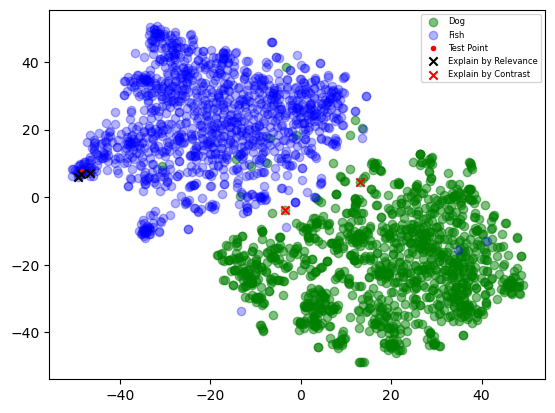

In [10]:
# Initialize the t-SNE algorithm
tsne = TSNE(n_components=2, random_state=42)

# Combine the training and test tensors
X = torch.cat((X_train, X_test), dim=0)
y = torch.cat((Y_train, Y_test), dim=0)

# Convert the tensors to numpy arrays
X = X.numpy()
y = y.numpy()

# Initialize the t-SNE algorithm
tsne = TSNE(n_components=2, random_state=0)

# Fit and transform the data to 2D
X_2d = tsne.fit_transform(X)

# Plot the data in 2D with different colors and alpha values for each class
plt.scatter(X_2d[y==0, 0], X_2d[y==0, 1], color='green', alpha=0.5, label='Dog')
plt.scatter(X_2d[y==1, 0], X_2d[y==1, 1], color='blue', alpha=0.3, label='Fish')

plt.scatter(X_2d[len(Y_train)+test_idx][0], X_2d[len(Y_train)+test_idx][1], marker='.', color='red', label='Test Point')

plt.scatter([X_2d[df_pos_sl.index[i]][0] for i in selected_indices_pos_sl],
        [X_2d[df_pos_sl.index[i]][1] for i in selected_indices_pos_sl], marker='x', color='black', label='Explain by Relevance')

plt.scatter([X_2d[df_pos_ol.index[i]][0] for i in selected_indices_pos_ol],
        [X_2d[df_pos_ol.index[i]][1] for i in selected_indices_pos_ol], marker='x', color='red', label='Explain by Contrast')

# plt.scatter([X_2d[df_neg_sl.index[i]][0] for i in selected_indices_neg_sl],
#         [X_2d[df_neg_sl.index[i]][1] for i in selected_indices_neg_sl], marker='+', color='orange', label='Support by Contrast')

# plt.scatter([X_2d[df_neg_ol.index[i]][0] for i in selected_indices_neg_ol],
#         [X_2d[df_neg_ol.index[i]][1] for i in selected_indices_neg_ol], marker='+', color='violet', label='Support by Relevance')



# plt.scatter([X_2d[df.sort_values('Influence', ascending=False).index[i]][0] for i in range(6)], [X_2d[df.sort_values('Influence', ascending=False).index[i]][1] for i in range(6)],
#             marker='+', color='pink', label='Influential Instances')
# plt.scatter([X_2d[df.sort_values('Similarity', ascending=False).index[i]][0] for i in range(6)], [X_2d[df.sort_values('Similarity', ascending=False).index[i]][1] for i in range(6)],
#             marker='+', color='brown', label='Similar Instances')

# plt.scatter([X_2d[df.sort_values('Influence', ascending=True).index[i]][0] for i in range(3)], [X_2d[df.sort_values('Influence', ascending=True).index[i]][1] for i in range(3)],
#             marker='x', color='pink', label='N_nfluential Instances')
# plt.scatter([X_2d[df.sort_values('Similarity', ascending=True).index[i]][0] for i in range(3)], [X_2d[df.sort_values('Similarity', ascending=True).index[i]][1] for i in range(3)],
#             marker='x', color='brown', label='Disimilar Instances')

# plt.scatter([X_2d[len(Y_train)+i][0] for i in f],
#         [X_2d[len(Y_train)+i][1] for i in f], marker='x', color='yellow',alpha=0.5, label='Incorrect predictions')


plt.legend(fontsize=6)
plt.show()

In [ ]:
selected_indices_pos_ol

In [ ]:
df_pos_ol

In [ ]:
plt.imshow(captioned_image(clf, embeds, 'test', 484))